<a href="https://colab.research.google.com/github/scottspurlock/mlfairness/blob/main/fair_mdn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating synthetic tabular data with MDN
## Scott Spurlock
### 6/28/2021
1. Train an autoencoder to encode tabular data into a lower dimensional representation, and decode the latent representation back to tabular data.
2. Train a mixture density network (MDN) to learn the conditional distribution over the latent space, given the class label and sensitive attribute (e.g., high income and sex, respectively, for the Adult dataset). Ideally, the MDN would be trained jointly with the autoencode to influence clustering in latent space, but for now this doesn't seem straightforward (backpropagating through random sampling seems challenging).
3. Use the MDN to generate synthetic samples of tabular data. Combine synth data with the original data to create a training set that is more fair. We call this approach SOS (Synthetic Oversampling).

For now, this doesn't seem to be working especially well. Issues:
- The synthetic examples are not very realistic. Possibly different representation would help, e.g., one-hot encoding.
- There is also a tendency toward MDN mode collapse, i.e., some gaussian mixes having a weight of 0.
- There is no constraint for the MDN to generate fair samples, beyond allowing us to generate examples from one of the 4 quadrants implied by male/female, high/low income. Unclear if a more explicit constraint is needed.

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# For MDN
import tensorflow_probability as tfp

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print(tf.__version__)
# !nvidia-smi

2.5.0


In [2]:
latent_dim = 8
epochs = 50
batch_size = 128
learning_rate = 5e-4
num_components = 5

## Load data

In [3]:
# Source: https://fairmlbook.org/code/adult.html
features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

# Change these to local file if available
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

# This will download 3.8M
original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
# This will download 1.9M
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)

# Drop Na values in train and test sets
original_train = original_train.dropna()
original_test = original_test.dropna()

num_train = len(original_train)
num_test = len(original_test)
original = pd.concat([original_train, original_test])
roc_original = original
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)
original

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K.
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [4]:
original.drop(['Target', 'Education', 'fnlwgt'], axis = 1, inplace = True)
original


,Age,Workclass,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...
16275,33,Private,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States
16276,39,Private,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
16278,38,Private,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
16279,44,Private,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


## Preprocessing
Make data numeric. Instead of one-hot encoding, we'll try just encoding as numeric values to hopefully improve data generation.

In [5]:
# numeric = pd.get_dummies(original)
# numeric.head()

categorical_features = ['Workclass', 'Martial Status', 'Occupation', 'Country','Relationship', 'Race', 'Sex']
continuous_features = ['Age','Capital Gain', 'Capital Loss', 'Hours per week']

numeric = original.copy()

for column in categorical_features:
  numeric[column] = numeric[column].astype('category').cat.codes

# Next, we will encode all continuous features to equally sized bins.
# for column in continuous_features:
#   min = numeric[column].min()
#   max = numeric[column].max()
#   feature_bins = pd.cut(numeric[column], bins=7, labels=False)
#   numeric.drop([column], axis=1, inplace=True)
#   numeric = pd.concat([numeric, feature_bins], axis=1)

numeric

,Age,Workclass,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39,5,13,4,0,1,4,1,2174,0,40,38
1,50,4,13,2,3,0,4,1,0,0,13,38
2,38,2,9,0,5,1,4,1,0,0,40,38
3,53,2,7,2,5,0,2,1,0,0,40,38
4,28,2,13,2,9,5,2,0,0,0,40,4
...,...,...,...,...,...,...,...,...,...,...,...,...
16275,33,2,13,4,9,3,4,1,0,0,40,38
16276,39,2,13,0,9,1,4,0,0,0,36,38
16278,38,2,13,2,9,0,4,1,0,0,50,38
16279,44,2,13,0,0,3,1,1,5455,0,40,38


In [6]:
X = numeric.values
y = labels.values.astype(np.float32)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)

# We need to split the data into train and test sets before normalizing.
scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.PowerTransformer()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

# Convert to TF Dataset for ease of training
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)

In [7]:
ytrain[:10]

array([0., 1., 0., 0., 0., 0., 0., 1., 0., 1.], dtype=float32)

In [64]:
def demographic_parity_gap(predicted, sensitive):
  '''
    predicted: binary vector (0's and 1's) of predicted labels
    sensitive: binary vector (0's and 1's) of sensitive attribute (e.g., sex)

    Output: P(ypred = 1 | s = 1) - P(ypred = 1 | s = 0)
  '''
  # Make sure we have properly shaped vectors
  predicted = np.reshape(predicted, (-1,))
  sensitive = np.reshape(sensitive, (-1,))
  if len(predicted) != len(sensitive):
    print('*** Error: mismatched shapes')

  mask_s0 = sensitive == 0
  mask_s1 = sensitive == 1
  mask_pred1 = predicted == 1
  count_0 = np.sum(mask_s0 & mask_pred1)
  count_1 = np.sum(mask_s1 & mask_pred1)

  prob0 = count_0 / np.sum(mask_s0)
  prob1 = count_1 / np.sum(mask_s1)
  diff = prob1 - prob0

  return diff

# Unit test
pred = np.array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0])
sensitive = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0])
print('Demographic Parity Score: {:.4f}'.format(demographic_parity_gap(pred, sensitive)))


Demographic Parity Score: -0.0833


## Create the model

In [8]:
def classifier(in_dim):
    inputs = keras.Input(shape=in_dim, name='input_layer')
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, output, name='classifier')
    return model

In [9]:
def encoder(in_dim, embedded_dim):
    inputs = keras.Input(shape=(in_dim,), name='input_layer')
    x = layers.Dense(embedded_dim, activation="relu")(inputs)
    model = tf.keras.Model(inputs, x, name='encoder')
    return model

In [10]:
def decoder(in_dim, out_dim):
    # Assuming that data has been min-max normalized, then the output has
    # sigmoid activation to put things in the 0 to 1 range.
    # Note that the input dimensionality to the decoder is generally the same
    # as the output from the encoder (embedded dimensions)
    inputs = keras.Input(shape=(in_dim,), name='input_layer')
    x = layers.Dense(out_dim, activation="sigmoid")(inputs)
    model = tf.keras.Model(inputs, x, name='decoder')
    return model  

In [11]:
# Given the label, y, output the distribution over the latent space
def make_mdn_model(num_components=5, latent_dim=8):
    event_shape = [latent_dim]
    num_components = num_components
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
    print('params_size:', params_size)

    input1 = keras.Input(shape=(1,), name='input_layer_target')
    x1 = layers.Dense(128, activation="relu", name='hidden_layer1')(input1)
    input2 = keras.Input(shape=(1,), name='input_layer_protected')
    x2 = layers.Dense(128, activation="relu", name='hidden_layer2')(input2)
    x = layers.Concatenate(axis=1)([x1, x2])
    x = layers.Dense(params_size, activation=None, name='penultimate_layer')(x)
    outp = tfp.layers.MixtureNormal(num_components=num_components, event_shape=event_shape)(x)
    model = tf.keras.Model([input1, input2], outp, name="mdn")
    return model

params_size: 85


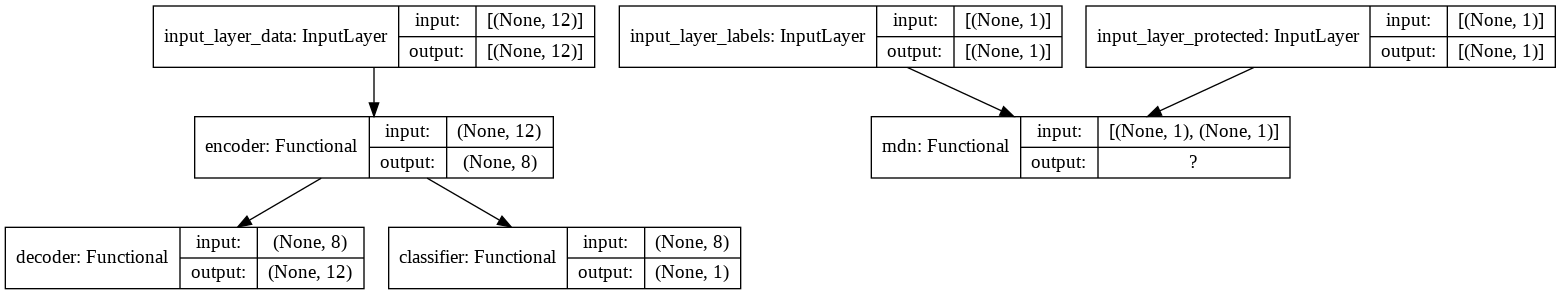

In [12]:
n_train, n_dim = Xtrain.shape

enc = encoder(n_dim, latent_dim)
dec = decoder(latent_dim, n_dim)
clf = classifier(latent_dim)
mdn = make_mdn_model(num_components, latent_dim)

input_data = keras.Input(shape=(n_dim,), name='input_layer_data')
input_labels = keras.Input(shape=(1,), name='input_layer_labels')
input_protected = keras.Input(shape=(1,), name='input_layer_protected')

model = tf.keras.Model(
			inputs=[input_data, input_labels, input_protected],
			outputs=[enc(input_data), dec(enc(input_data)), clf(enc(input_data)), mdn([input_labels, input_protected])],
			name="mdn_ae")

# plot the autoencoder
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)


In [13]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure(figsize=(10, 10))
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()


In [14]:
loss_func_dec = tf.keras.losses.mean_squared_error
loss_func_mdn = lambda y, q: -q.log_prob(y)
loss_func_clf = tf.keras.losses.binary_crossentropy
loss_func_entropy = lambda w: -tf.reduce_sum(w * tf.math.log(w), axis=1)
# lw = [1000, 1, 100, 1]
lw = [1, 1, 100, 1]

opt = keras.optimizers.Adam(learning_rate=learning_rate)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    X, y = batch
    y = tf.reshape(y, [-1, 1])

    # HACK: pull out protected attribute - hardcoded column 7
    s = X[:, 7]

    # print('DEBUG train_step:', X.shape, y.shape)

    with tf.GradientTape() as tape:
      # Forward pass
      z, Xhat, yhat, gmm = model([X, y, s])
      # print('  ending forward pass...')

      # Losses
      loss_dec = loss_func_dec(X, Xhat)
      # print('  loss_dec', loss_dec)
      loss_mdn = loss_func_mdn(z, gmm)
      # print('  loss_mdn', loss_mdn)
      # print('  classifier loss... y', y.shape, ', yhat', yhat.shape)
      loss_clf = loss_func_clf(y, yhat)
      # print('  loss_clf', loss_clf)
      loss_entropy = -loss_func_entropy(gmm.mixture_distribution.probs_parameter())
      # print('  loss_entropy', loss_entropy)
      # loss_gmm_recon = tf.keras.losses.mean_squared_error(X, gmm.components_distribution.mean()[:, 0])
      loss = lw[0] * loss_dec + lw[1] * loss_mdn + lw[2] * loss_clf + lw[3]*loss_entropy #+ lw[4]*loss_gmm_recon
      # print('  total loss', loss)

    grads = tape.gradient(loss, model.trainable_variables)
    # print('DEBUG:\n', grads)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    # print('DEBUG ... ', y.dtype, yhat.dtype)
    acc_dec = tf.keras.metrics.binary_accuracy(y, yhat, 0.5)

    return tf.reduce_mean(loss, axis=None), \
           tf.reduce_mean(loss_dec, axis=None), \
           tf.reduce_mean(loss_mdn, axis=None), \
           tf.reduce_mean(loss_clf, axis=None), \
           tf.reduce_mean(loss_entropy, axis=None), \
           tf.reduce_mean(acc_dec, axis=None)

def train(dataset, epochs):
  # losses = np.zeros((epochs,))
  # Keep results for plotting
  train_loss_results = []
  train_accuracy_results = []

  for epoch in range(epochs):
    print('Epoch {:02d} of {:02d} ...'.format(epoch+1, epochs))
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_loss_dec = tf.keras.metrics.Mean()
    epoch_loss_mdn = tf.keras.metrics.Mean()
    epoch_loss_clf = tf.keras.metrics.Mean()
    epoch_loss_entropy = tf.keras.metrics.Mean()
    # epoch_loss_gmm_recon = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.Mean()

    start = time.time()

    for curr_batch in dataset:
      ret = train_step(curr_batch)
      loss_value, loss_dec, loss_mdn, loss_clf, loss_entropy, acc_dec = ret

      # Track progress
      epoch_loss_avg.update_state(loss_value)  # Add current batch loss
      epoch_loss_dec.update_state(loss_dec)  
      epoch_loss_mdn.update_state(loss_mdn)  
      epoch_loss_clf.update_state(loss_clf)  
      epoch_loss_entropy.update_state(loss_entropy)  
      # epoch_loss_gmm_recon.update_state(loss_gmm_recon)  
      epoch_accuracy.update_state(acc_dec)

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 1 == 0:
      print("Epoch {:03d}: Loss: {:.3f}, DEC: {:.3f}, MDN: {:.3f}, CLF: {:.3f}, ENT: {:.3f}, Acc: {:.3%}".format(epoch+1,
                                                                  epoch_loss_avg.result(),
                                                                  epoch_loss_dec.result(),
                                                                  epoch_loss_mdn.result(),
                                                                  epoch_loss_clf.result(),
                                                                  epoch_loss_entropy.result(),
                                                                  epoch_accuracy.result()))
    
    # # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # print('  over {} batches, avg loss is {:.4f}'.format(batches, avg_loss))

    # ---------
    # Show examples


  return train_loss_results, train_accuracy_results


Epoch 01 of 50 ...
Epoch 001: Loss: 48.729, DEC: 0.130, MDN: -6.684, CLF: 0.567, ENT: -1.427, Acc: 74.771%
Time for epoch 1 is 5.149232625961304 sec
Epoch 02 of 50 ...
Epoch 002: Loss: 26.644, DEC: 0.116, MDN: -25.428, CLF: 0.533, ENT: -1.394, Acc: 75.384%
Time for epoch 2 is 1.7633299827575684 sec
Epoch 03 of 50 ...
Epoch 003: Loss: 28.480, DEC: 0.106, MDN: -22.585, CLF: 0.524, ENT: -1.397, Acc: 75.485%
Time for epoch 3 is 2.559506893157959 sec
Epoch 04 of 50 ...
Epoch 004: Loss: 20.553, DEC: 0.097, MDN: -29.956, CLF: 0.518, ENT: -1.383, Acc: 75.435%
Time for epoch 4 is 2.550184965133667 sec
Epoch 05 of 50 ...
Epoch 005: Loss: 16.488, DEC: 0.090, MDN: -33.427, CLF: 0.512, ENT: -1.343, Acc: 75.499%
Time for epoch 5 is 1.7807555198669434 sec
Epoch 06 of 50 ...
Epoch 006: Loss: 15.326, DEC: 0.084, MDN: -34.042, CLF: 0.506, ENT: -1.317, Acc: 75.533%
Time for epoch 6 is 1.7962045669555664 sec
Epoch 07 of 50 ...
Epoch 007: Loss: 12.147, DEC: 0.079, MDN: -36.734, CLF: 0.501, ENT: -1.301, Acc

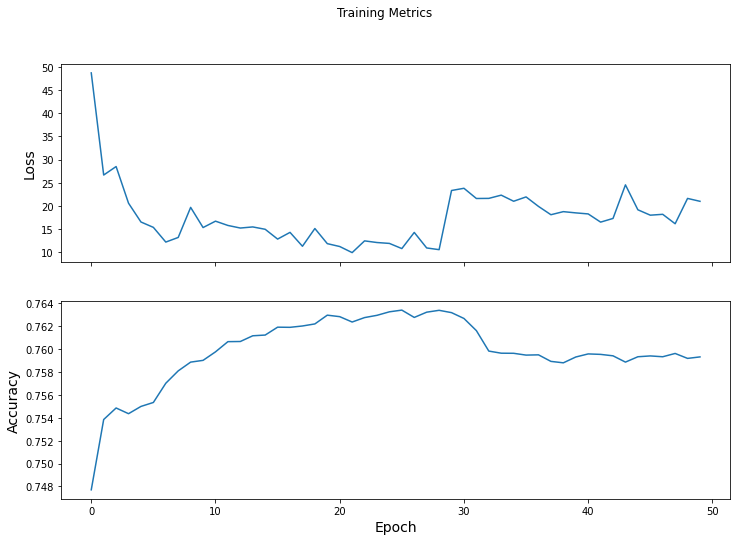

In [15]:
train_loss_results, train_accuracy_results = train(train_dataset, epochs)

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()


Test Accuracy: 10125.340532173657
Demographic Parity Score: -0.0590


              precision    recall  f1-score   support

         0.0       0.77      0.99      0.87     10258
         1.0       0.78      0.06      0.11      3309

    accuracy                           0.77     13567
   macro avg       0.77      0.53      0.49     13567
weighted avg       0.77      0.77      0.68     13567



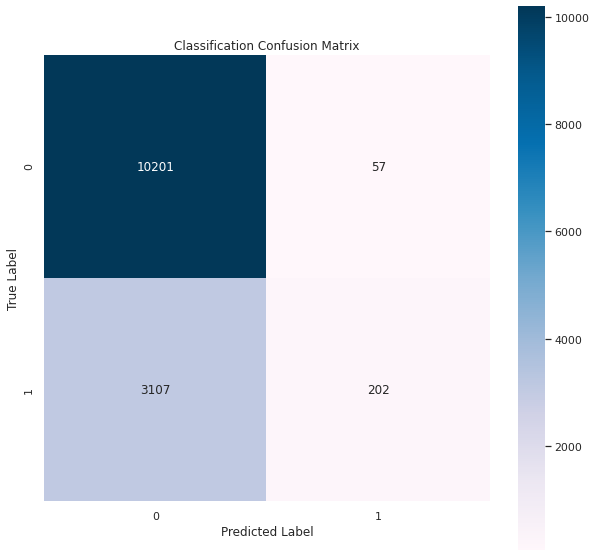

In [65]:
# Check accuracy

# Encode the input image
z = enc(Xtest)

# Classify the latent code
ypred = clf(z)
# ypred = [1 if cy >= 0.5 else 0 for cy in ypred]
ypred = np.where(ypred >= 0.5, 1, 0)
acc = np.sum(ypred == ytest)/len(ytest)
# acc = tf.keras.metrics.binary_accuracy(ytest, ypred, threshold=0.5)
print('Test Accuracy:', acc)
print('Demographic Parity Score: {:.4f}'.format(demographic_parity_gap(ypred, Xtest[:, 7])))
print('\n')
print(classification_report(ytest, ypred))

cm = confusion_matrix(ytest, ypred)


plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu")

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Classification Confusion Matrix')
plt.show()


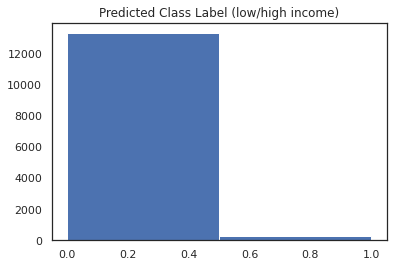

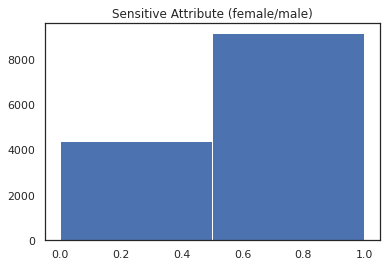

In [44]:
plt.figure()
plt.hist(ypred, 2)
plt.title('Predicted Class Label (low/high income)')
plt.show()

plt.figure()
plt.hist(Xtest[:, 7], 2)
plt.title('Sensitive Attribute (female/male)')
plt.show()

0 - 0 :  ( 0.08713720851951598 0.005506442225496004 )   1.8565267324447632 0.588844045996666
0 - 1 :  ( 0.192554518554244 0.04237146029343436 )   2.663358747959137 0.5762452632188797
0 - 2 :  ( 0.11639800808529774 0.0020876483068222595 )   1.9932125508785248 1.0266673564910889
0 - 3 :  ( 0.08622744632881445 0.018965230144266227 )   11.489402055740356 1.7729240655899048
0 - 4 :  ( 0.0947388756124575 0.0016914044677604073 )   1.9974994659423828 0.9073295444250107
1 - 0 :  ( -0.03552137993837253 0.03563525857244755 )   2.056427150964737 0.02396779367700219
1 - 1 :  ( 0.09927653909064384 0.051167342735528504 )   2.157217413187027 0.023285264614969492
1 - 2 :  ( -0.02856576149756033 0.06261554716192667 )   2.0769116282463074 0.059090107679367065
1 - 3 :  ( -0.04191291419076534 -0.004030752685050515 )   11.632039546966553 0.14946652576327324
1 - 4 :  ( -0.2312360063769735 0.08517627614141464 )   2.0774060487747192 0.11113550513982773
2 - 0 :  ( 0.07420452693046048 0.03137135755851999 )   2.0

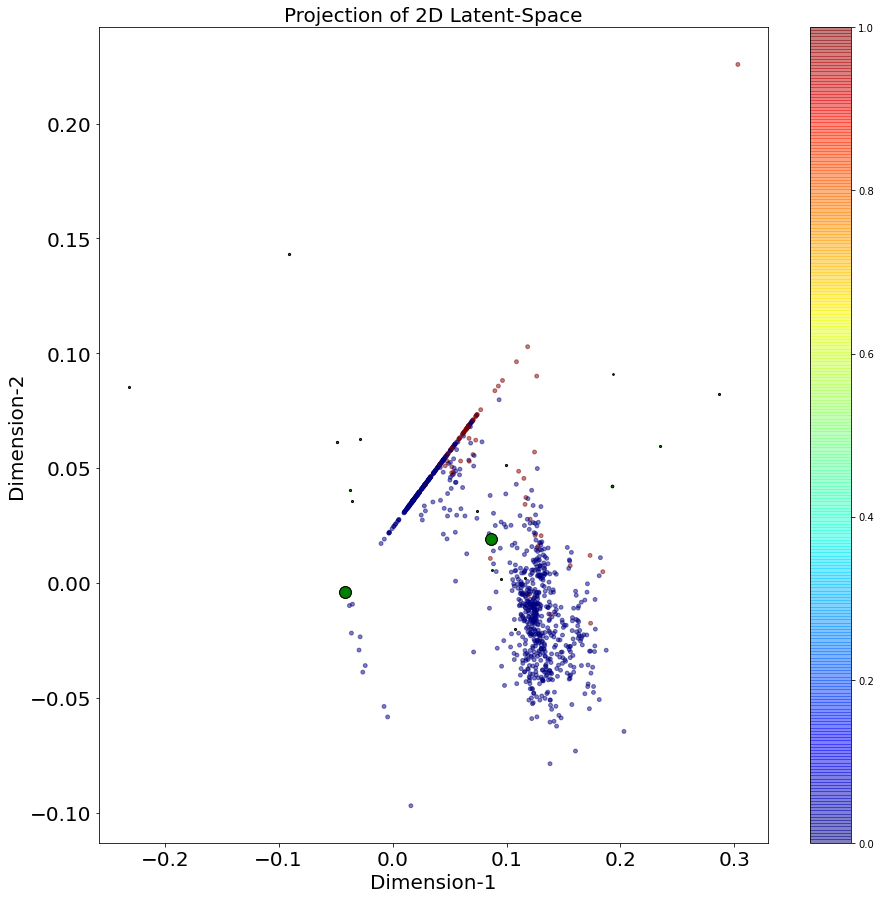

In [17]:
imgs_visualize = 3000
figsize = 15
show_gmm_modes = True

def plot_label_clusters(data, labels, use_pca=False):
    # display a 2D plot of the digit classes in the latent space
    z = enc(data)

    if use_pca:
      pca = PCA(n_components=2)
      pca.fit(z)
      z = pca.transform(z)


    plt.figure(figsize=(figsize, figsize))
    plt.scatter(z[:, 0], z[:, 1], 15, c=labels, cmap='jet', alpha=0.5)

    if show_gmm_modes:
      labels_income = np.array([[0], [0], [1], [1]])
      labels_sex = np.array([[0], [1], [0], [1]])
      gmm = mdn([labels_income, labels_sex], training=False)
      for i in range(4):
        for k in range(num_components):
          z = gmm.components_distribution.mean()[i, k].numpy()
          w = 20*gmm.mixture_distribution.probs_parameter().numpy()[i, k]
          s = gmm.components_distribution.stddev()[i, k].numpy()
          s = 10*np.linalg.norm(s)
          # print('Digit {:d} ({:d}): ({:.2f}, {:.2f}) {:.4f} {:.4f}'.format(i, k, z[0], z[1], w, s))
          if use_pca:
            # print(z.shape)
            z = np.reshape(z, (1, -1))
            # print(z.shape)
            z = pca.transform(z)
            # print(z.shape)
            z = np.reshape(z, (2,))

          print(i, '-', k, ':  (', z[0], z[1], ')  ', w, s)
          plt.plot(z[0], z[1], 'ok', MarkerSize=w, MarkerFaceColor='green')

    plt.colorbar()
    plt.xlabel("Dimension-1", size=20)
    plt.ylabel("Dimension-2", size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("Projection of 2D Latent-Space", size=20)
    plt.show()

plot_label_clusters(Xtrain[:imgs_visualize], ytrain[:imgs_visualize], True)


In [18]:
numeric.head(10)

,Age,Workclass,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39,5,13,4,0,1,4,1,2174,0,40,38
1,50,4,13,2,3,0,4,1,0,0,13,38
2,38,2,9,0,5,1,4,1,0,0,40,38
3,53,2,7,2,5,0,2,1,0,0,40,38
4,28,2,13,2,9,5,2,0,0,0,40,4
5,37,2,14,2,3,5,4,0,0,0,40,38
6,49,2,5,3,7,1,2,0,0,0,16,22
7,52,4,9,2,3,0,4,1,0,0,45,38
8,31,2,14,4,9,1,4,0,14084,0,50,38
9,42,2,13,2,3,0,4,1,5178,0,40,38


In [19]:
labels_income = np.array([[0], [0], [1], [1]])
labels_sex = np.array([[0], [1], [0], [1]])

results = np.zeros((num_components*4, Xtest.shape[1]+3))
gmm = mdn([labels_income, labels_sex], training=False)

idx1 = 0
idx2 = 0

for idx1 in range(4):
  for k in range(num_components):
    z = gmm.components_distribution.mean()[idx1, k]
    z = tf.reshape(z, (1, -1))
    xhat = dec(z)
    xhat = scaler.inverse_transform(xhat)
    w = gmm.mixture_distribution.probs_parameter().numpy()[idx1, k]
    s = gmm.components_distribution.stddev()[idx1, k].numpy()
    results[idx2, 0] = labels_income[idx1]
    results[idx2, 1] = labels_sex[idx1]
    results[idx2, 2] = w
    results[idx2, 3:] = xhat
    idx2 += 1

disp = pd.DataFrame(results, columns=['Income', 'Sex', 'Weight']+list(numeric.columns.values))

for k in range(4):
  print(disp.iloc[k*num_components:(k+1)*num_components])

   Income  Sex  Weight  ...  Capital Loss  Hours per week  Country
0     0.0  0.0     0.1  ...         101.6            37.7     36.7
1     0.0  0.0     0.1  ...          74.9            33.1     37.0
2     0.0  0.0     0.1  ...          89.2            36.2     36.7
3     0.0  0.0     0.6  ...         101.9            37.9     36.7
4     0.0  0.0     0.1  ...          95.3            36.0     36.6

[5 rows x 15 columns]
   Income  Sex  Weight  ...  Capital Loss  Hours per week  Country
5     0.0  1.0     0.1  ...         173.3            46.1     36.4
6     0.0  1.0     0.1  ...         116.4            36.1     36.8
7     0.0  1.0     0.1  ...         165.2            47.7     36.2
8     0.0  1.0     0.6  ...         165.3            42.6     36.3
9     0.0  1.0     0.1  ...         364.5            55.3     35.3

[5 rows x 15 columns]
    Income  Sex  Weight  ...  Capital Loss  Hours per week  Country
10     1.0  0.0     0.1  ...         110.3            40.7     36.7
11     1.0  0.

In [20]:
disp.Weight

0    0.1
1    0.1
2    0.1
3    0.6
4    0.1
      ..
15   0.1
16   0.1
17   0.1
18   0.6
19   0.1
Name: Weight, Length: 20, dtype: float64

In [21]:
!pip install table_evaluator


  Created wheel for table-evaluator: filename=table_evaluator-1.2.2.post1-py3-none-any.whl size=17050 sha256=f07b863ecbb70aea69ce84d79c6340bda94cd2cd4c3ff7530172fe35ff5526c2
  Stored in directory: /root/.cache/pip/wheels/45/c7/20/47a3f8b044d705f3c088d9577968a805dded4b83096fabd2ac
Successfully built table-evaluator


In [22]:
from table_evaluator import load_data, TableEvaluator


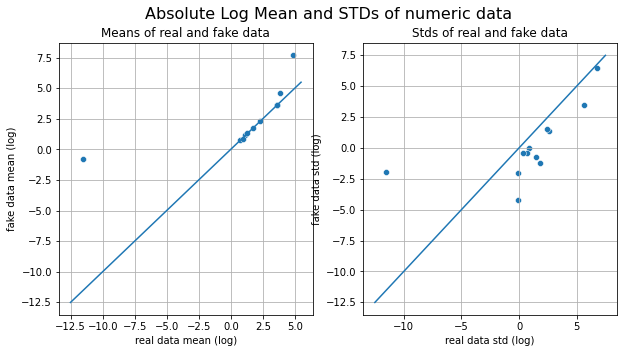

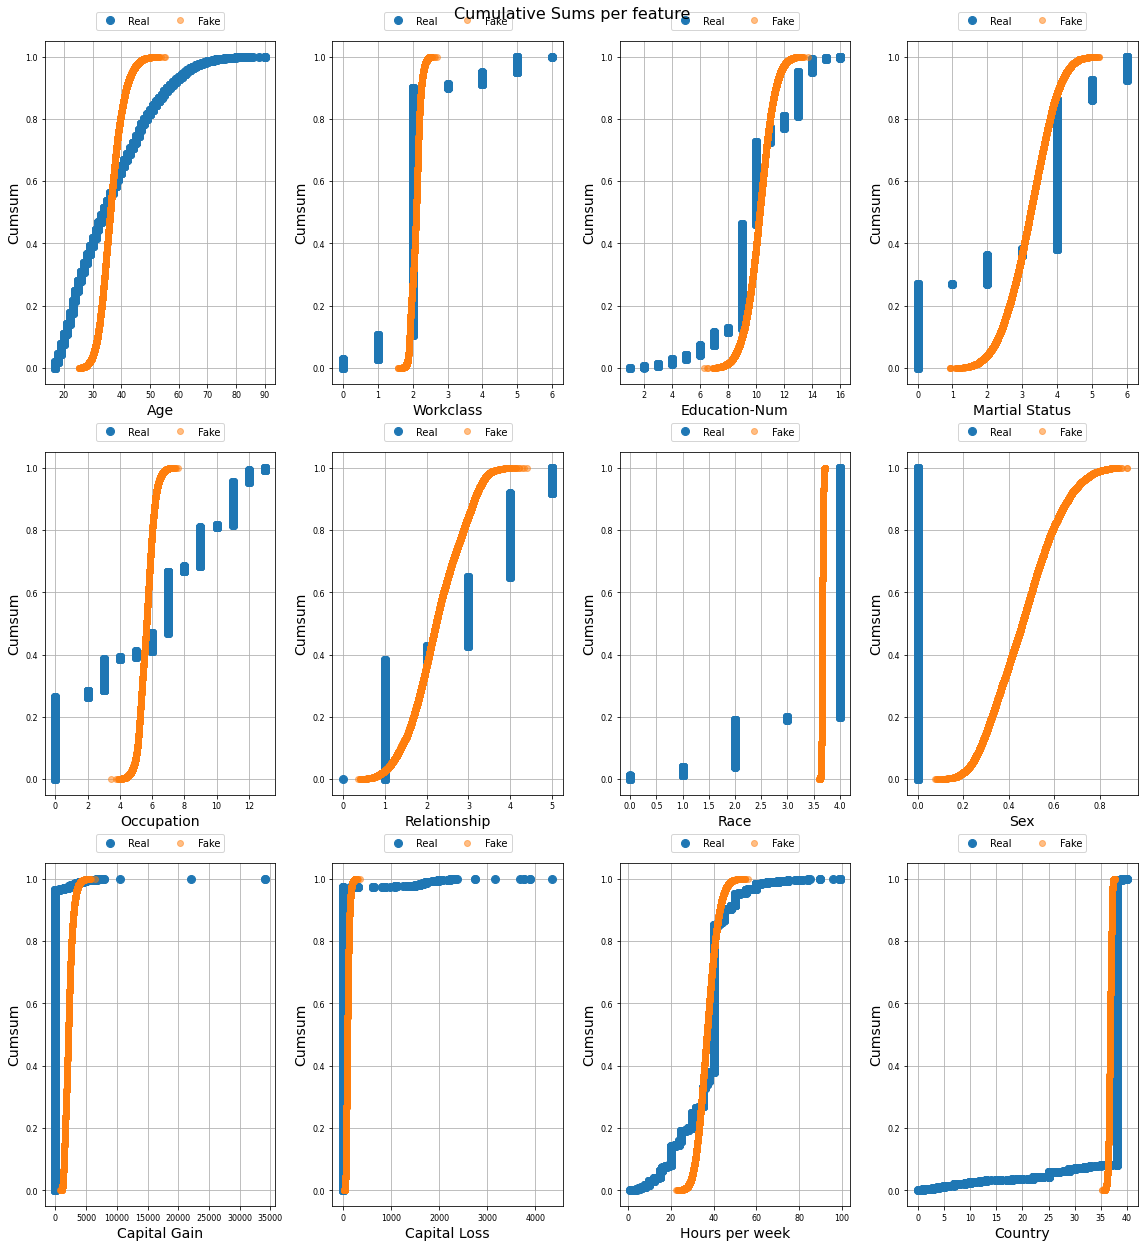

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

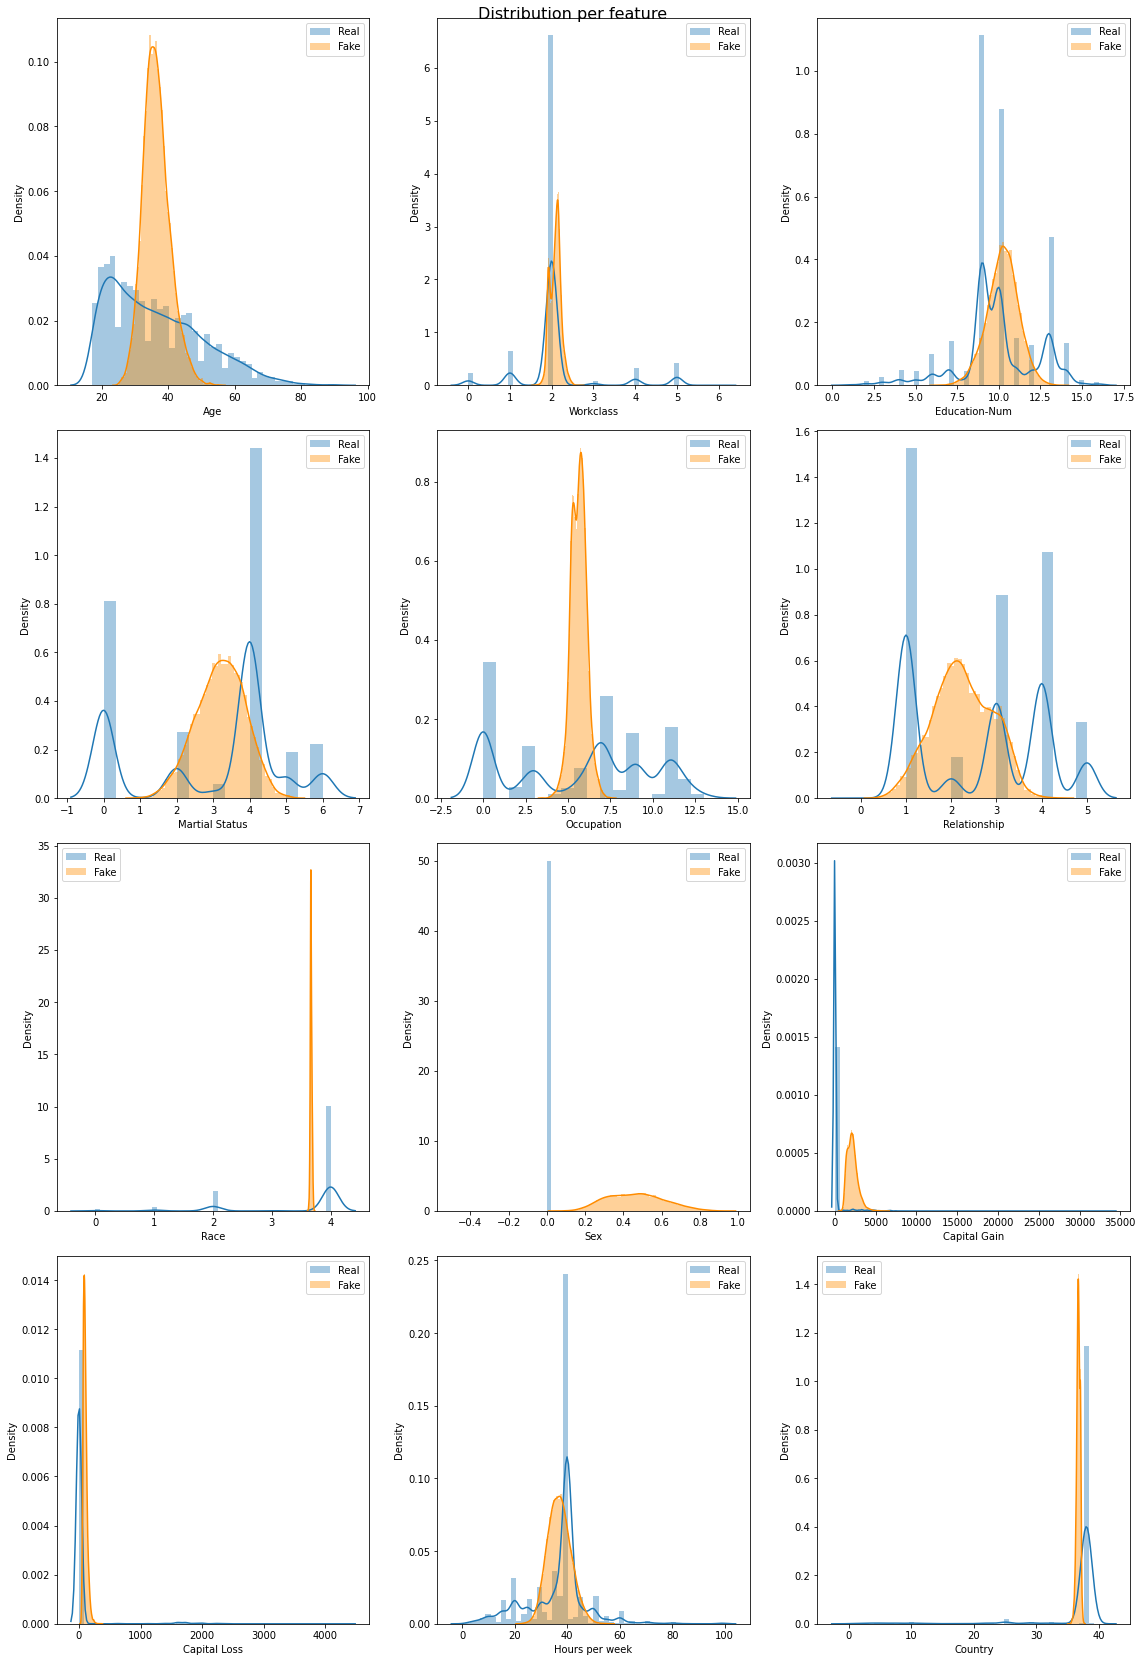

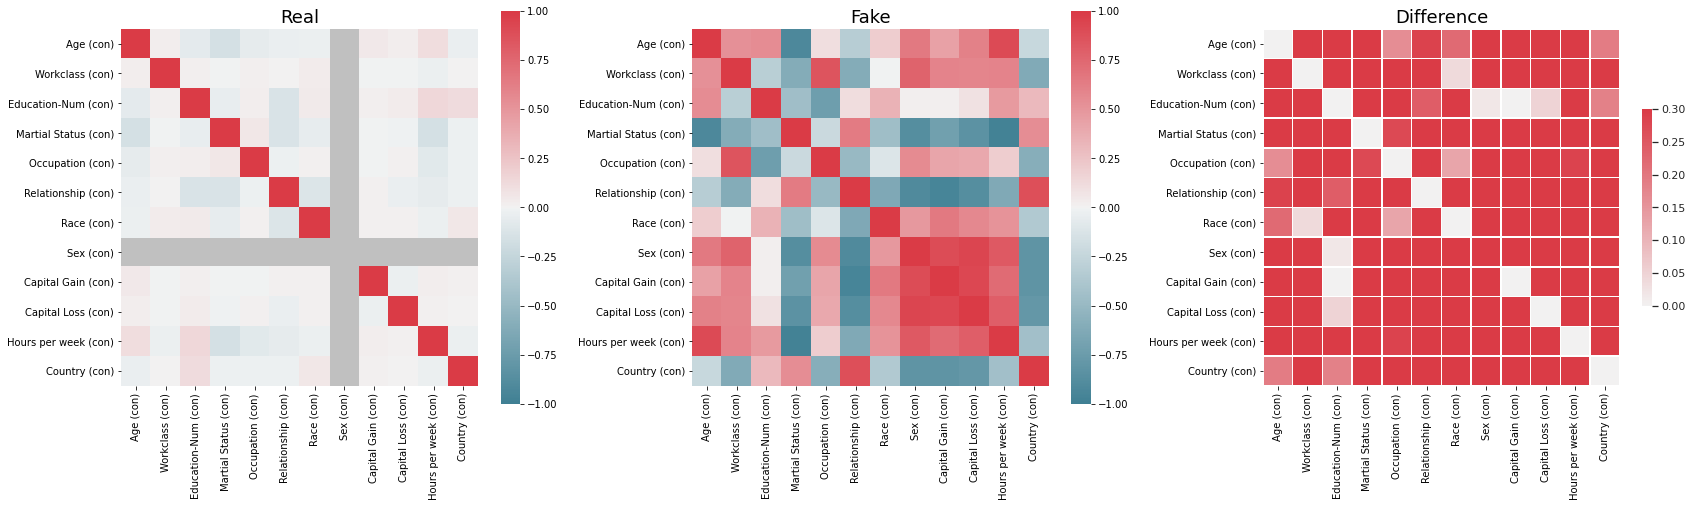

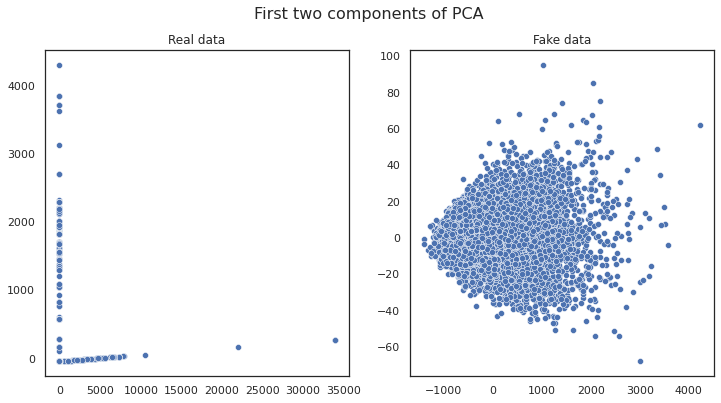

In [23]:
# Random sampling from the MDN

# Low income, female
# HACK: protecte attribute is column 7
mask = (y == 0) & (X[:, 7] == 0)
gt_samples = numeric[mask]
num_samples = gt_samples.shape[0]

curr_target = np.zeros((num_samples, 1))
curr_protected = np.zeros((num_samples, 1))

gmm = mdn([curr_target, curr_protected], training=False)
sample = gmm.sample()

xhat = dec(sample)
xhat = scaler.inverse_transform(xhat)
samples = pd.DataFrame(xhat, columns=numeric.columns)

table_evaluator =  TableEvaluator(gt_samples, samples)
table_evaluator.visual_evaluation()

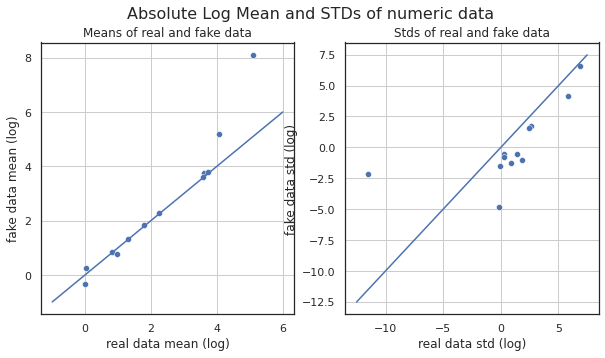

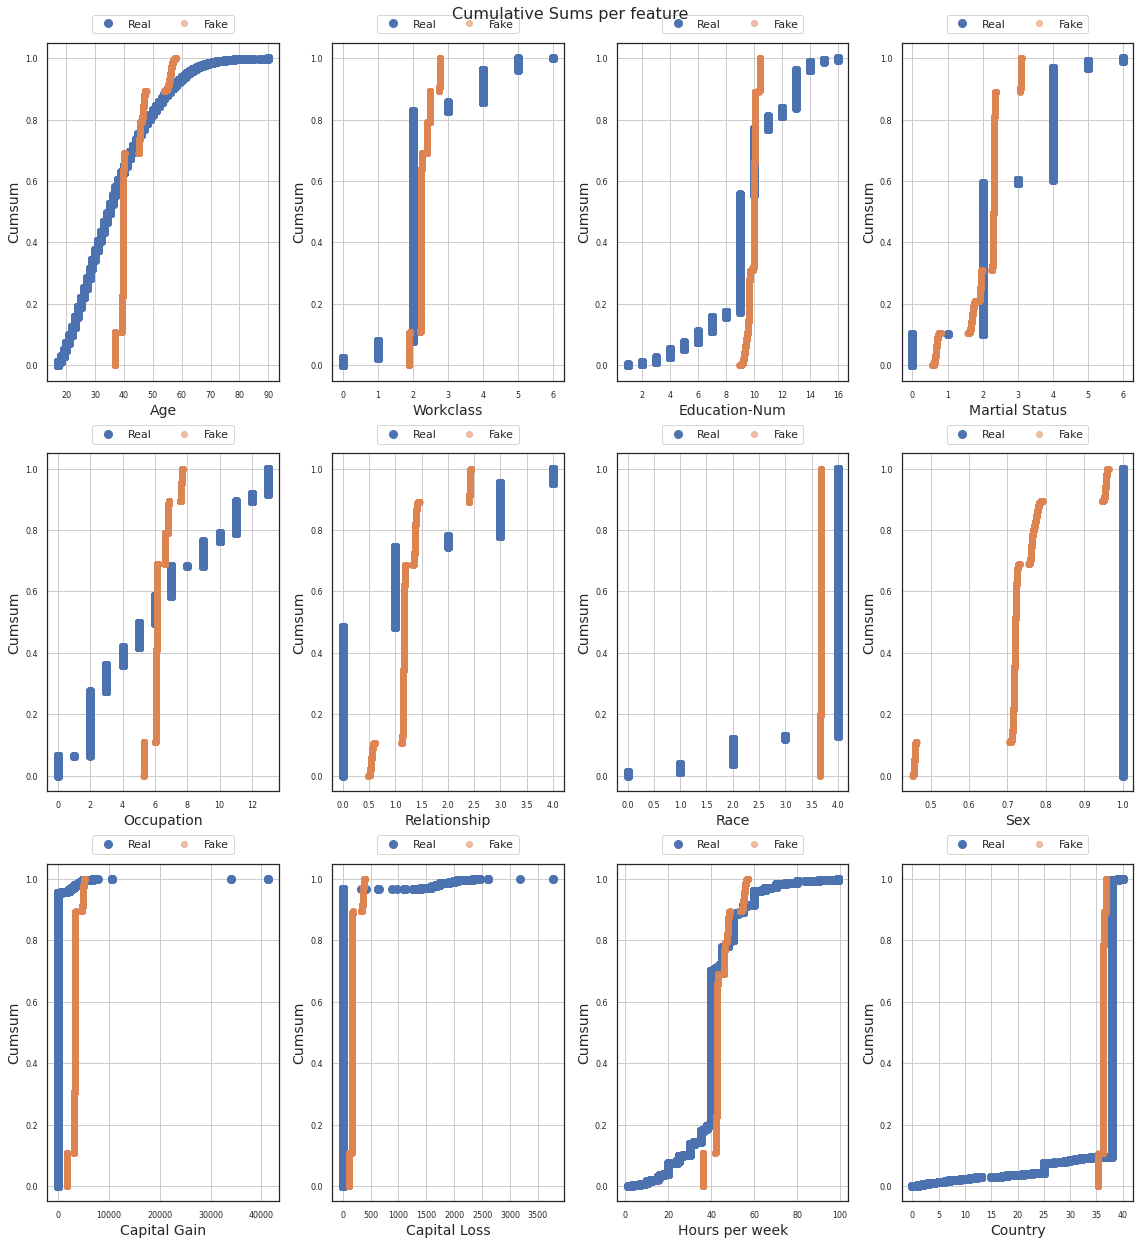

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

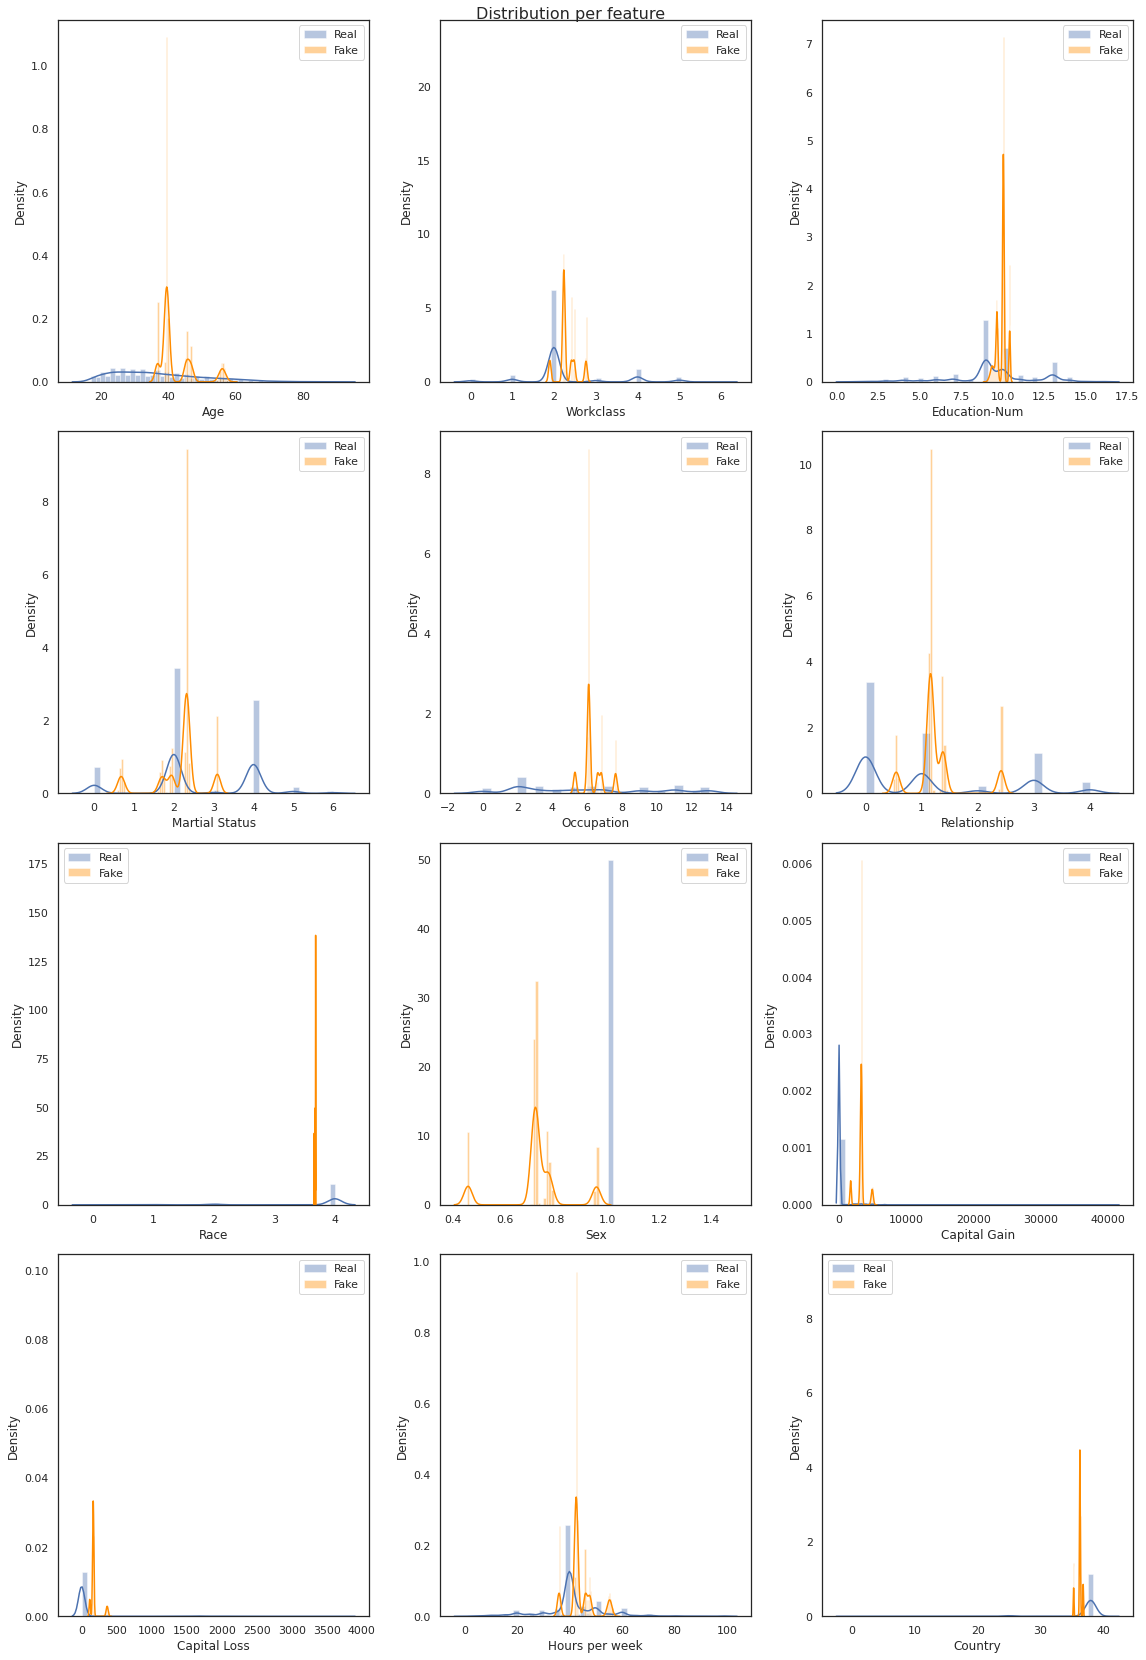

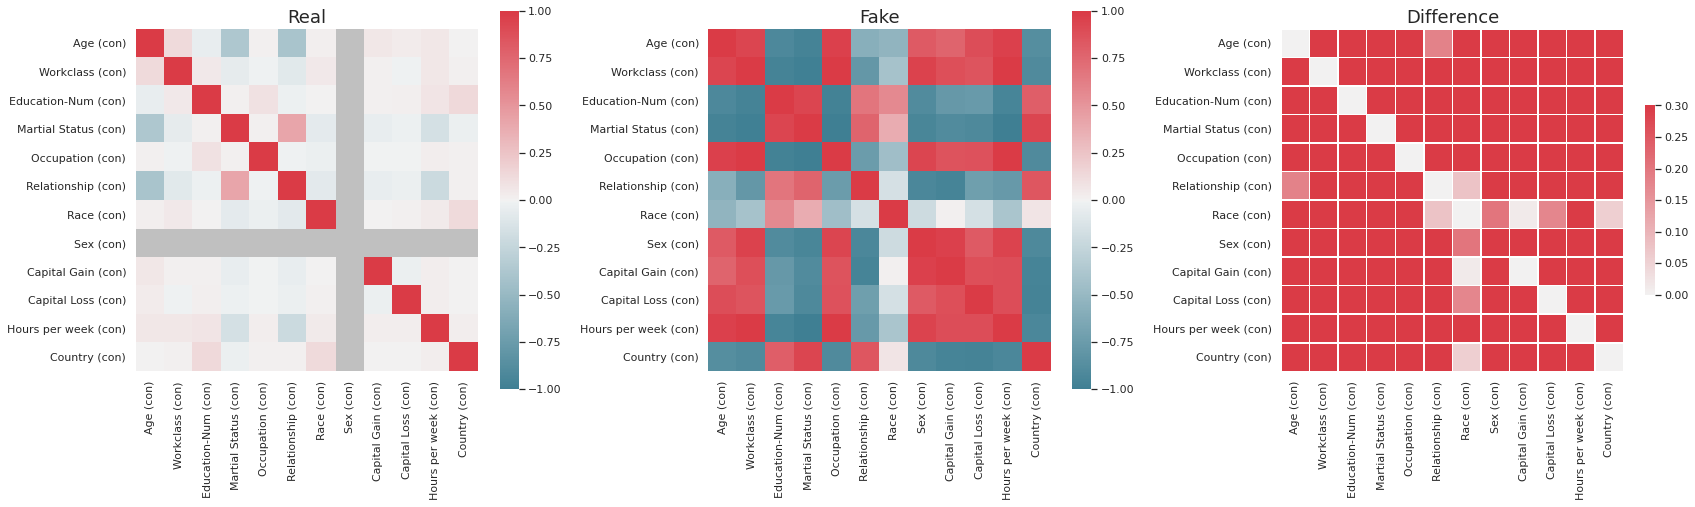

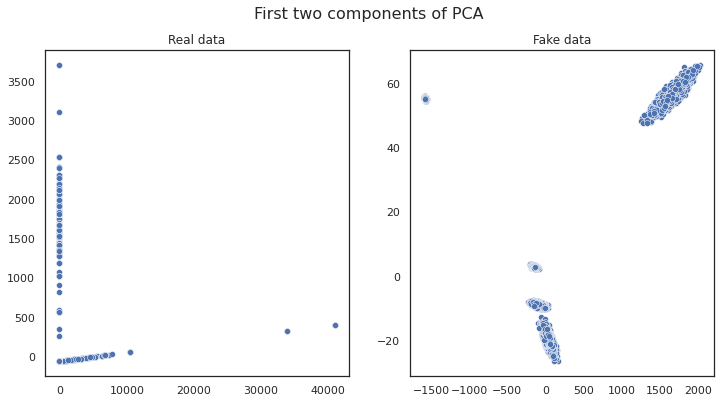

In [24]:
# Random sampling from the MDN

# Low income, male
# HACK: protecte attribute is column 7
mask = (y == 0) & (X[:, 7] == 1)
gt_samples = numeric[mask]
num_samples = gt_samples.shape[0]

curr_target = np.zeros((num_samples, 1))
curr_protected = np.ones((num_samples, 1))

gmm = mdn([curr_target, curr_protected], training=False)
sample = gmm.sample()

xhat = dec(sample)
xhat = scaler.inverse_transform(xhat)
samples = pd.DataFrame(xhat, columns=numeric.columns)

table_evaluator =  TableEvaluator(gt_samples, samples)
table_evaluator.visual_evaluation()

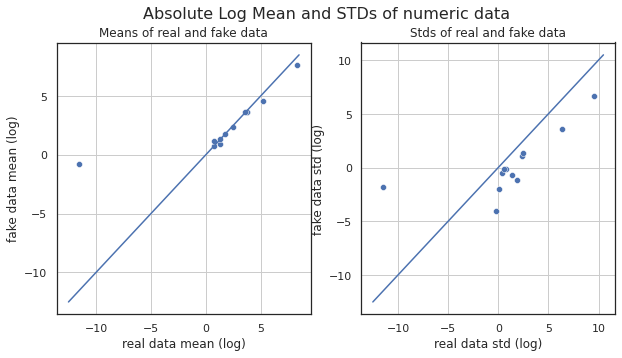

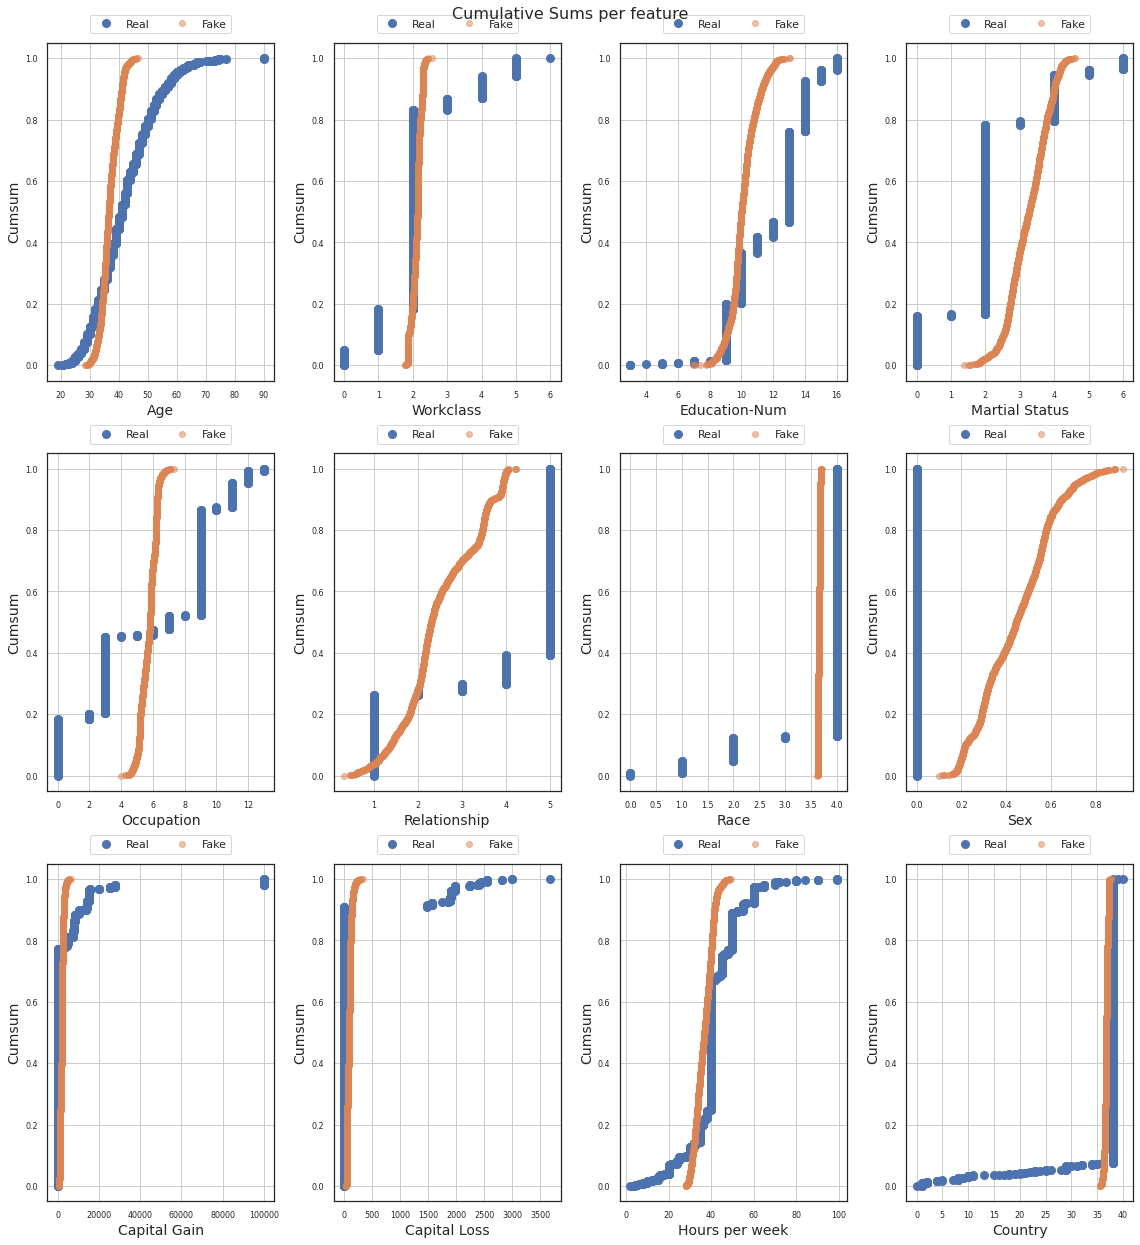

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

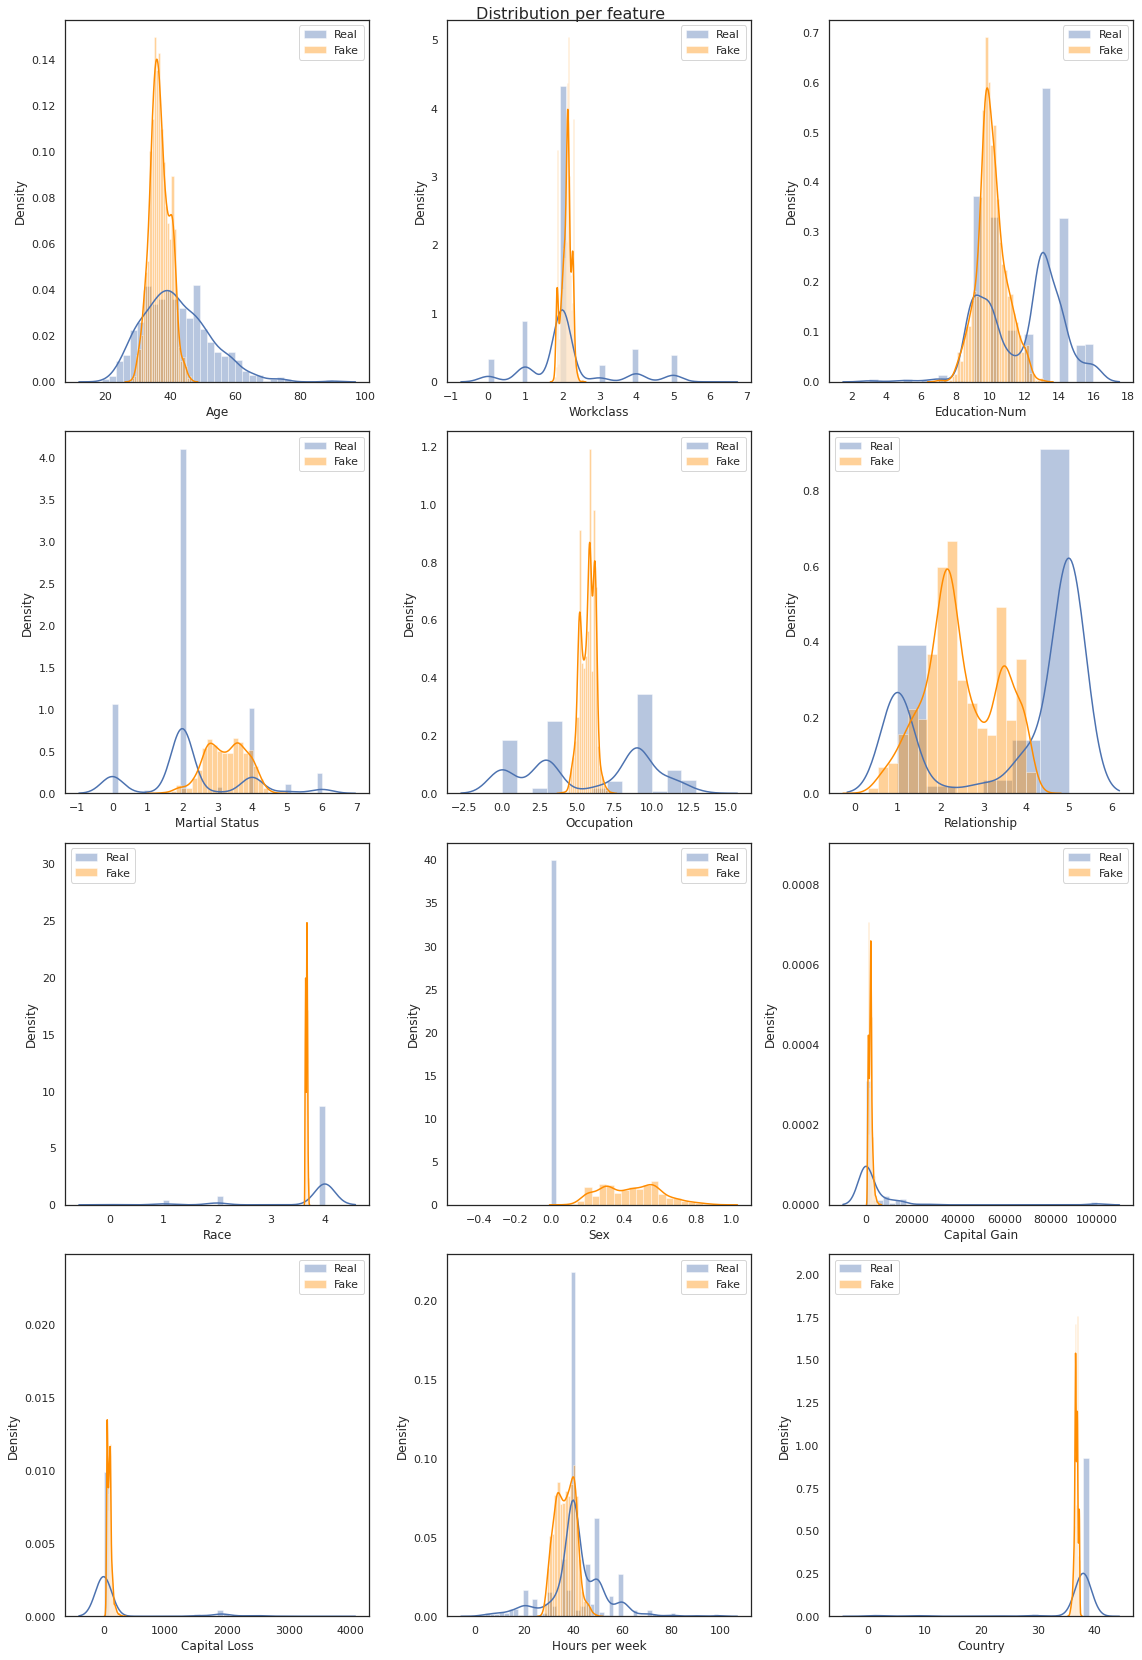

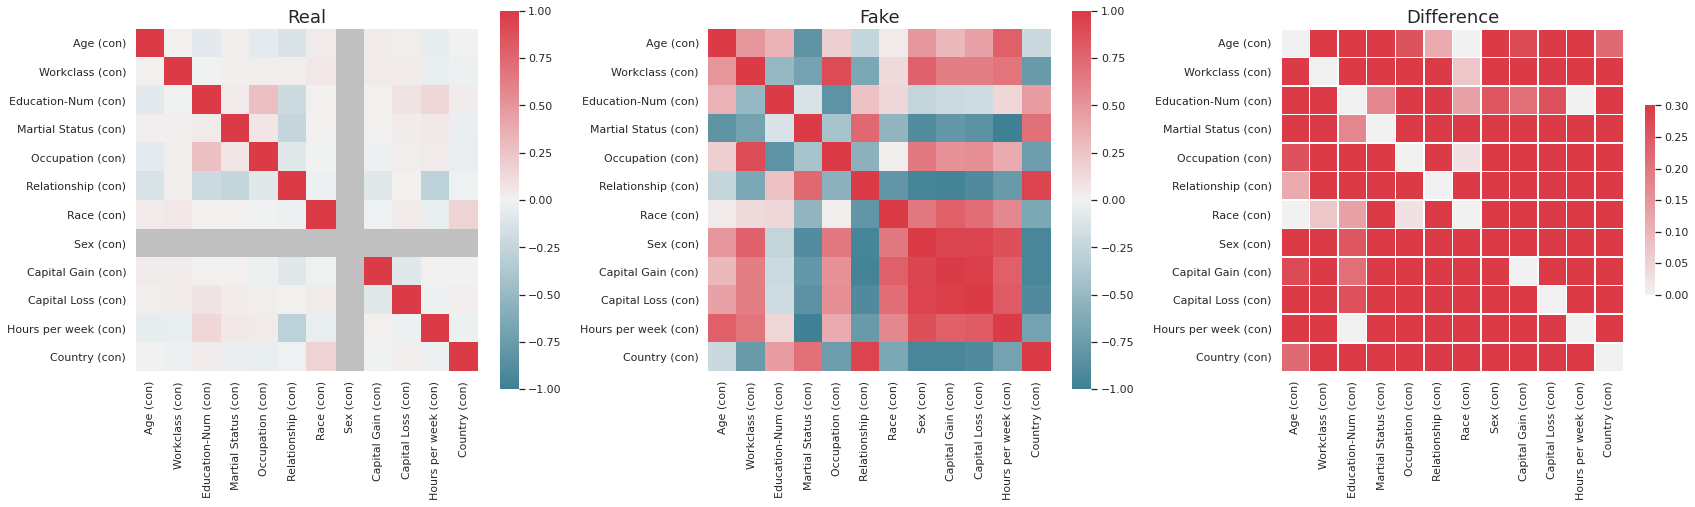

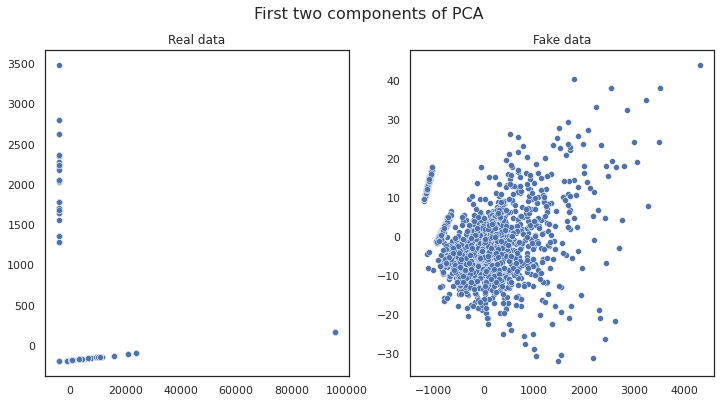

In [25]:
# Random sampling from the MDN

# High income, female
# HACK: protecte attribute is column 7
mask = (y == 1) & (X[:, 7] == 0)
gt_samples = numeric[mask]
num_samples = gt_samples.shape[0]

curr_target = np.ones((num_samples, 1))
curr_protected = np.zeros((num_samples, 1))

gmm = mdn([curr_target, curr_protected], training=False)
sample = gmm.sample()

xhat = dec(sample)
xhat = scaler.inverse_transform(xhat)
samples = pd.DataFrame(xhat, columns=numeric.columns)

table_evaluator =  TableEvaluator(gt_samples, samples)
table_evaluator.visual_evaluation()

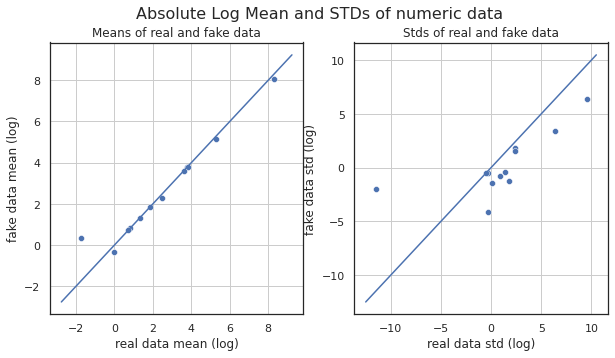

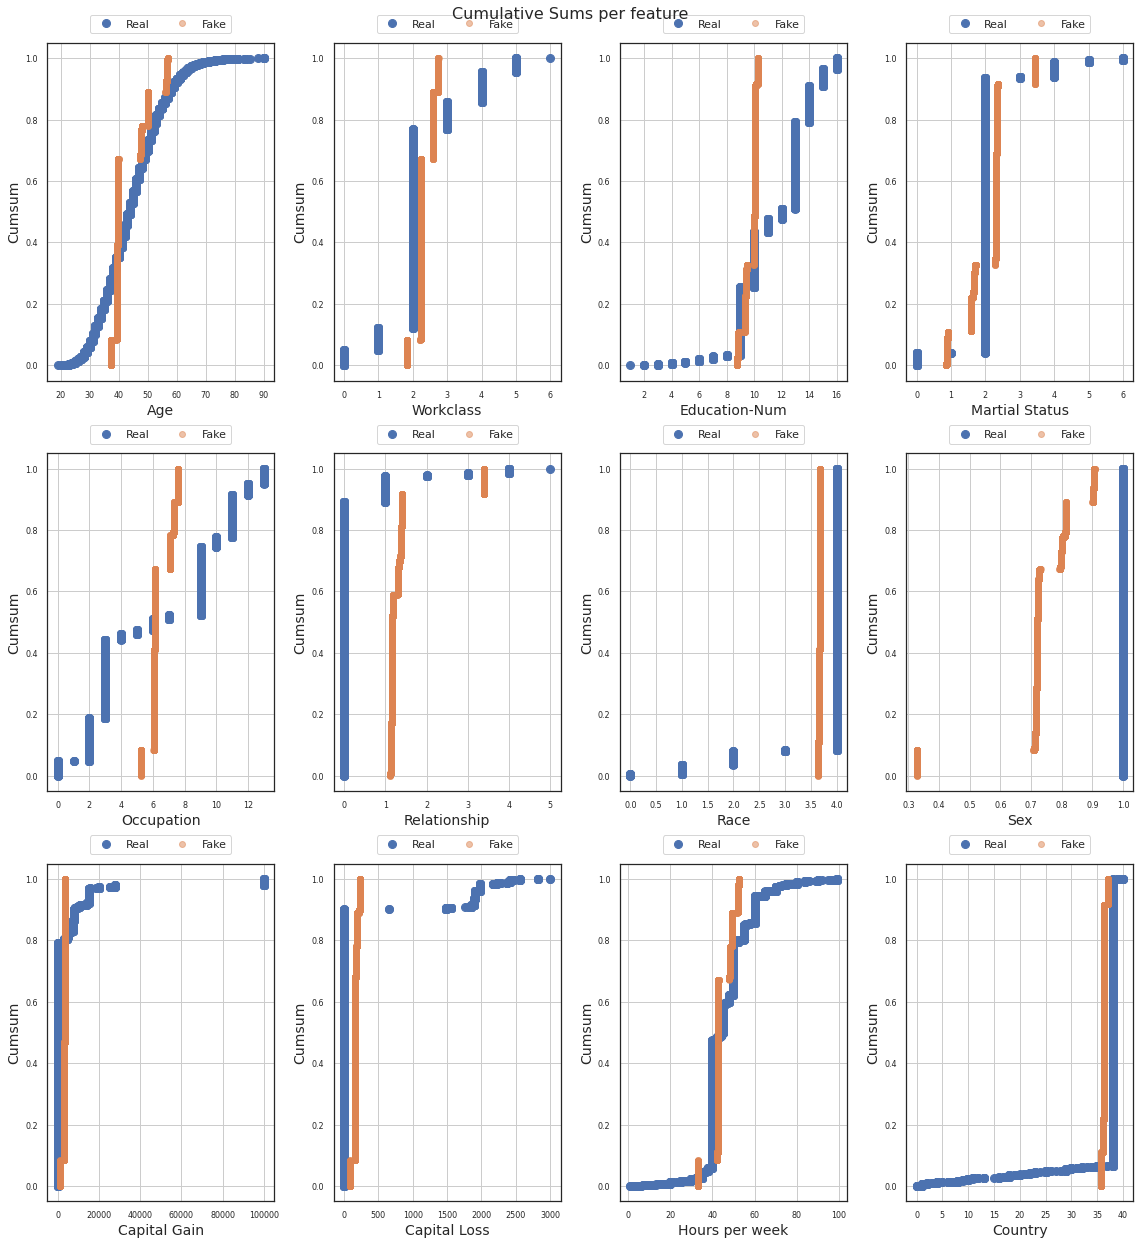

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

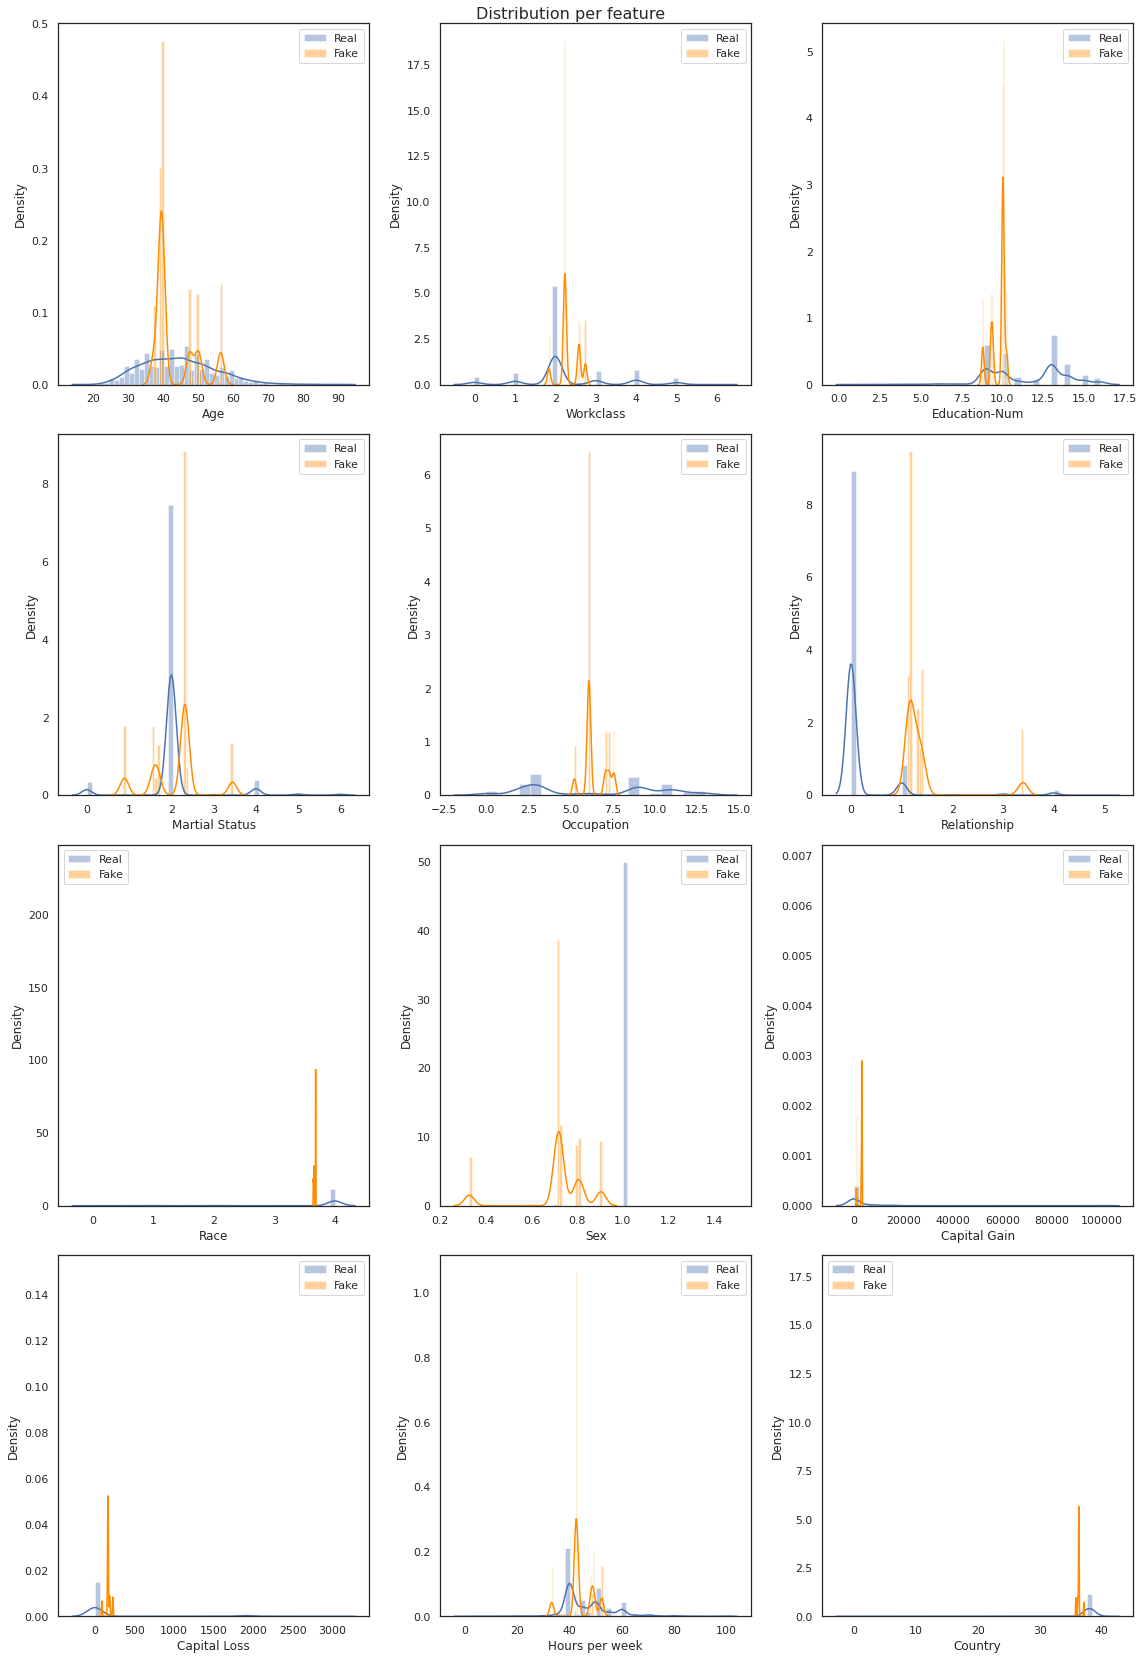

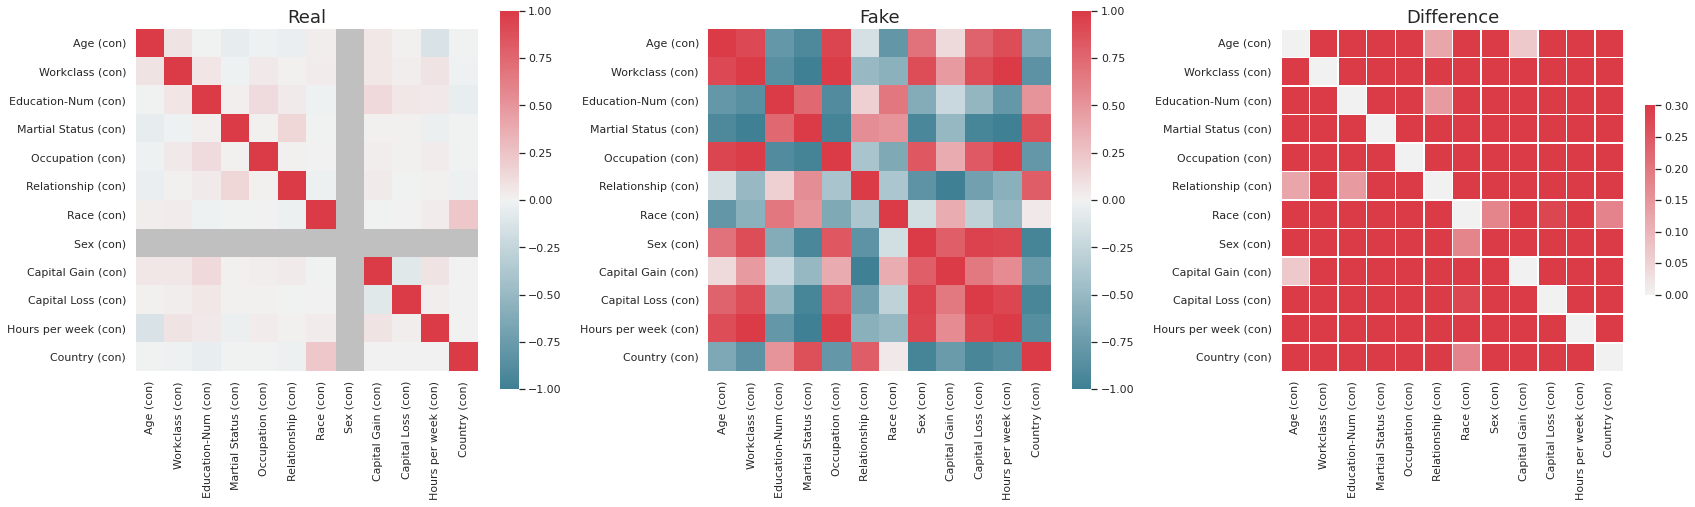

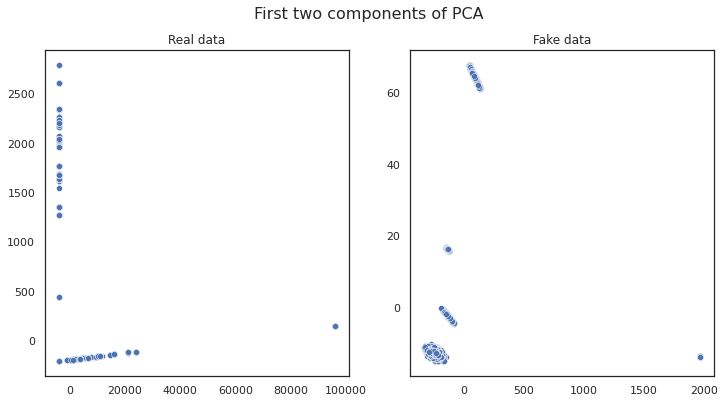

In [26]:
# Random sampling from the MDN

# High income, male
# HACK: protecte attribute is column 7
mask = (y == 1) & (X[:, 7] == 1)
gt_samples = numeric[mask]
num_samples = gt_samples.shape[0]

curr_target = np.ones((num_samples, 1))
curr_protected = np.ones((num_samples, 1))

gmm = mdn([curr_target, curr_protected], training=False)
sample = gmm.sample()

xhat = dec(sample)
xhat = scaler.inverse_transform(xhat)
samples = pd.DataFrame(xhat, columns=numeric.columns)

table_evaluator =  TableEvaluator(gt_samples, samples)
table_evaluator.visual_evaluation()

# Check accuracy with generated data

In [27]:
# Generate data
num_samples = 100000
curr_target = np.random.randint(0, 2, num_samples)
curr_protected = np.random.randint(0, 2, num_samples)
print(curr_protected.shape)

gmm = mdn([curr_target, curr_protected], training=False)
sample = gmm.sample()

xhat = dec(sample)
# X2 = scaler.inverse_transform(xhat)
X2 = xhat
y2 = curr_target

(100000,)


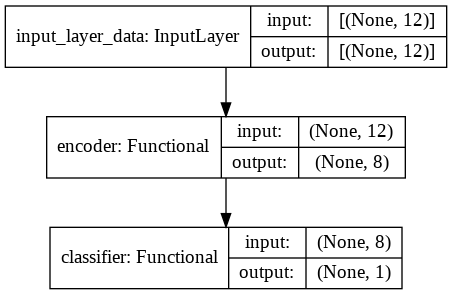

In [28]:
# Make classifier model
input_data2 = keras.Input(shape=(n_dim,), name='input_layer_data')

enc2 = encoder(n_dim, latent_dim)
clf2 = classifier(latent_dim)

model2 = tf.keras.Model(
			inputs=input_data2,
			outputs=clf2(enc2(input_data2)),
			name="simple_classifier")

# plot the model
tf.keras.utils.plot_model(model2, 'model2.png', show_shapes=True)

In [29]:
# Train with generated data
opt2 = keras.optimizers.Adam(learning_rate=learning_rate)
model2.compile(optimizer=opt2, loss='binary_crossentropy', metrics=[tf.keras.metrics.binary_accuracy])
hist2 = model2.fit(X2, y2, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
704/704 [==============================] - 2s 2ms/step - loss: 0.6643 - binary_accuracy: 0.5827 - val_loss: 0.6220 - val_binary_accuracy: 0.6262
Epoch 2/50
704/704 [==============================] - 1s 2ms/step - loss: 0.6017 - binary_accuracy: 0.6242 - val_loss: 0.5976 - val_binary_accuracy: 0.5948
Epoch 3/50
704/704 [==============================] - 1s 2ms/step - loss: 0.5889 - binary_accuracy: 0.6231 - val_loss: 0.5905 - val_binary_accuracy: 0.6479
Epoch 4/50
704/704 [==============================] - 1s 2ms/step - loss: 0.5823 - binary_accuracy: 0.6302 - val_loss: 0.5825 - val_binary_accuracy: 0.6281
Epoch 5/50
704/704 [==============================] - 1s 2ms/step - loss: 0.5770 - binary_accuracy: 0.6415 - val_loss: 0.5786 - val_binary_accuracy: 0.6064
Epoch 6/50
704/704 [==============================] - 1s 2ms/step - loss: 0.5717 - binary_accuracy: 0.6485 - val_loss: 0.5750 - val_binary_accuracy: 0.6412
Epoch 7/50
704/704 [==============================] - 1s 2ms/ste

Test Accuracy: 0.7667870568290706
Demographic Parity Score: -0.0590


Test Accuracy: 0.6289526055870863
Demographic Parity Score: -0.0373


              precision    recall  f1-score   support

         0.0       0.73      0.81      0.77     10258
         1.0       0.12      0.08      0.09      3309

    accuracy                           0.63     13567
   macro avg       0.42      0.44      0.43     13567
weighted avg       0.58      0.63      0.60     13567



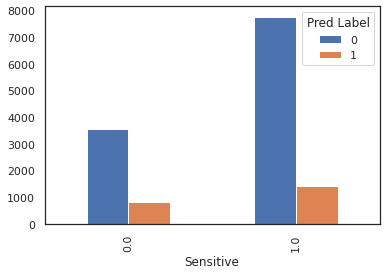

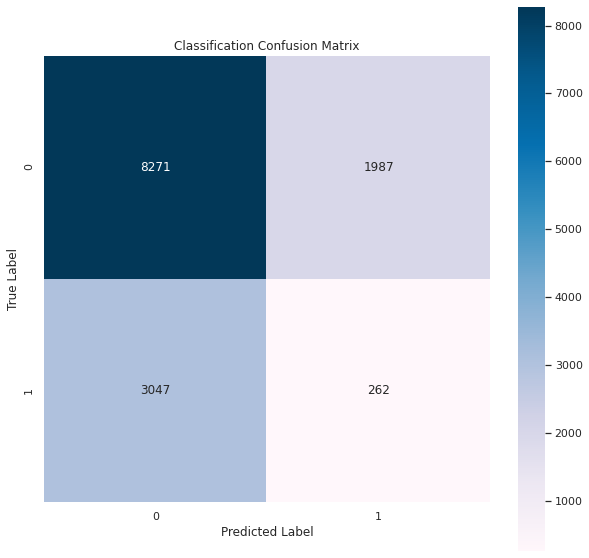

In [70]:
# Check accuracy

# Encode the input data
z = enc(Xtest)

# Classify the latent code
ypred = clf(z)
# ypred = [1 if cy >= 0.5 else 0 for cy in ypred]
ypred = np.reshape(ypred, (-1, ))
ypred = np.where(ypred >= 0.5, 1, 0)

acc = np.sum(ypred == ytest)/len(ytest)
# acc = tf.keras.metrics.binary_accuracy(ytest, ypred, threshold=0.5)
print('Test Accuracy:', acc)
print('Demographic Parity Score: {:.4f}'.format(demographic_parity_gap(ypred, Xtest[:, 7])))
print('\n')

# ------------------------------

z = enc2(Xtest)

# Classify the latent code
ypred = clf2(z)
ypred = np.reshape(ypred, (-1, ))
ypred = np.where(ypred >= 0.5, 1, 0)
acc = np.sum(ypred == ytest)/len(ytest)
print('Test Accuracy:', acc)
sensitive = Xtest[:, 7]
print('Demographic Parity Score: {:.4f}'.format(demographic_parity_gap(ypred, sensitive)))
print('\n')
visdf = pd.DataFrame(list(zip(sensitive, ypred)), columns=['Sensitive', 'Pred Label'])
ct = pd.crosstab(visdf['Sensitive'], visdf['Pred Label'])
ct.plot(kind='bar');

print(classification_report(ytest, ypred))

cm = confusion_matrix(ytest, ypred)


plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu")

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Classification Confusion Matrix')
plt.show()

In [67]:
visdf

,Sensitive,Pred Label
0,0.0,[0]
1,1.0,[1]
2,1.0,[0]
3,0.0,[1]
4,1.0,[0]
...,...,...
13562,1.0,[0]
13563,0.0,[0]
13564,1.0,[0]
13565,0.0,[1]


# Now try combining the original training data with the generated data to train a classifier.

In [31]:
# Generate data
num_samples = 10000
curr_target = np.ones((num_samples,)) #np.random.randint(0, 2, num_samples)
curr_protected = np.random.randint(0, 2, num_samples)
print(curr_protected.shape)

gmm = mdn([curr_target, curr_protected], training=False)
sample = gmm.sample()

xhat = dec(sample)
# X2 = scaler.inverse_transform(xhat)
X3 = xhat
y3 = curr_target

(10000,)


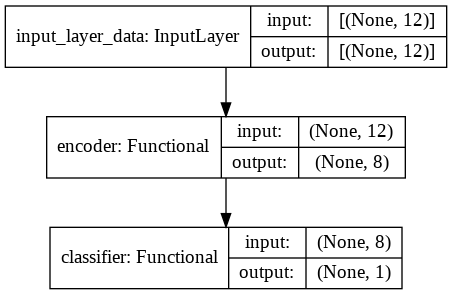

In [32]:
# Make classifier model
input_data3 = keras.Input(shape=(n_dim,), name='input_layer_data')

enc3 = encoder(n_dim, latent_dim)
clf3 = classifier(latent_dim)

model3 = tf.keras.Model(
			inputs=input_data3,
			outputs=clf3(enc3(input_data3)),
			name="simple_classifier2")

# plot the model
tf.keras.utils.plot_model(model3, 'model3.png', show_shapes=True)

In [33]:

# Combine original and generated data
X4 = np.concatenate((Xtrain, X3), axis=0)
y4 = np.concatenate((ytrain, y3))
print(X4.shape, y4.shape)

(41655, 12) (41655,)


In [34]:
# Train
opt3 = keras.optimizers.Adam(learning_rate=learning_rate)
model3.compile(optimizer=opt3, loss='binary_crossentropy', metrics=[tf.keras.metrics.binary_accuracy])
hist3 = model3.fit(X4, y4, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
293/293 [==============================] - 1s 3ms/step - loss: 0.5605 - binary_accuracy: 0.7105 - val_loss: 0.2545 - val_binary_accuracy: 0.9998
Epoch 2/50
293/293 [==============================] - 1s 2ms/step - loss: 0.4054 - binary_accuracy: 0.8266 - val_loss: 0.1396 - val_binary_accuracy: 1.0000
Epoch 3/50
293/293 [==============================] - 1s 2ms/step - loss: 0.3725 - binary_accuracy: 0.8384 - val_loss: 0.1021 - val_binary_accuracy: 0.9995
Epoch 4/50
293/293 [==============================] - 1s 2ms/step - loss: 0.3519 - binary_accuracy: 0.8453 - val_loss: 0.0821 - val_binary_accuracy: 0.9993
Epoch 5/50
293/293 [==============================] - 1s 2ms/step - loss: 0.3371 - binary_accuracy: 0.8492 - val_loss: 0.0754 - val_binary_accuracy: 0.9993
Epoch 6/50
293/293 [==============================] - 1s 2ms/step - loss: 0.3264 - binary_accuracy: 0.8524 - val_loss: 0.0520 - val_binary_accuracy: 1.0000
Epoch 7/50
293/293 [==============================] - 1s 2ms/ste

Test Accuracy: 0.7667870568290706
Demographic Parity Score: -0.0590


Test Accuracy: 0.6289526055870863
Demographic Parity Score: -0.0373


Test Accuracy: 0.8418957765165475
Demographic Parity Score: 0.1792


              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90     10258
         1.0       0.72      0.58      0.64      3309

    accuracy                           0.84     13567
   macro avg       0.79      0.75      0.77     13567
weighted avg       0.83      0.84      0.84     13567



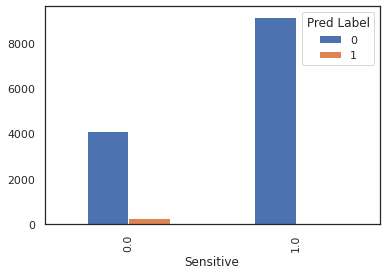

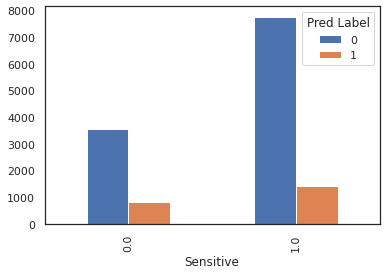

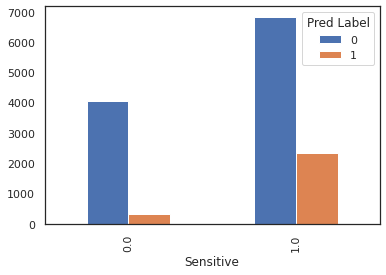

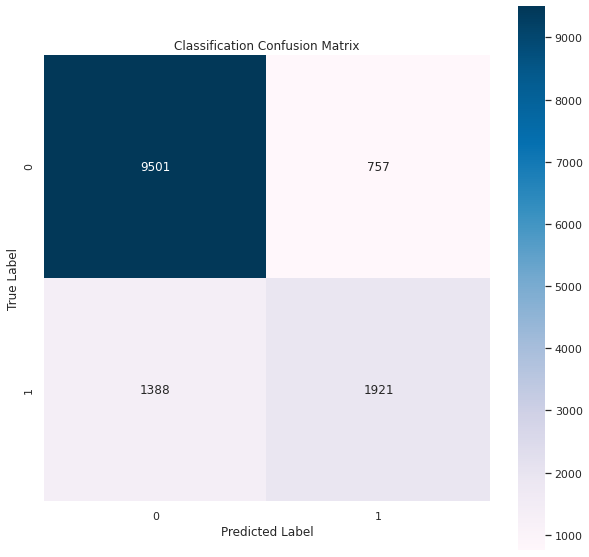

In [71]:
# Check accuracy

# Encode the input data
z = enc(Xtest)

# Classify the latent code
ypred = clf(z)
ypred = np.reshape(ypred, (-1, ))
ypred = np.where(ypred >= 0.5, 1, 0)
acc = np.sum(ypred == ytest)/len(ytest)
print('Test Accuracy:', acc)
sensitive = Xtest[:, 7]
print('Demographic Parity Score: {:.4f}'.format(demographic_parity_gap(ypred, sensitive)))
print('\n')
visdf = pd.DataFrame(list(zip(sensitive, ypred)), columns=['Sensitive', 'Pred Label'])
ct = pd.crosstab(visdf['Sensitive'], visdf['Pred Label'])
ct.plot(kind='bar');

# ------------------------------

# Encode the input data
z = enc2(Xtest)

# Classify the latent code
ypred = clf2(z)
ypred = np.reshape(ypred, (-1, ))
ypred = np.where(ypred >= 0.5, 1, 0)
acc = np.sum(ypred == ytest)/len(ytest)
print('Test Accuracy:', acc)
sensitive = Xtest[:, 7]
print('Demographic Parity Score: {:.4f}'.format(demographic_parity_gap(ypred, sensitive)))
print('\n')
visdf = pd.DataFrame(list(zip(sensitive, ypred)), columns=['Sensitive', 'Pred Label'])
ct = pd.crosstab(visdf['Sensitive'], visdf['Pred Label'])
ct.plot(kind='bar');

# ------------------------------

z = enc3(Xtest)

# Classify the latent code
ypred = clf3(z)
ypred = np.reshape(ypred, (-1, ))
ypred = np.where(ypred >= 0.5, 1, 0)
acc = np.sum(ypred == ytest)/len(ytest)
print('Test Accuracy:', acc)
sensitive = Xtest[:, 7]
print('Demographic Parity Score: {:.4f}'.format(demographic_parity_gap(ypred, sensitive)))
print('\n')
visdf = pd.DataFrame(list(zip(sensitive, ypred)), columns=['Sensitive', 'Pred Label'])
ct = pd.crosstab(visdf['Sensitive'], visdf['Pred Label'])
ct.plot(kind='bar');

print(classification_report(ytest, ypred))

cm = confusion_matrix(ytest, ypred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu")

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Classification Confusion Matrix')
plt.show()